# ResNet BNPP Training Notebook

This notebook implements a ResNet neural network for BNPP regression with comprehensive training, validation, and testing capabilities.


In [52]:
# Install required packages (run this cell first)
%pip install torch torchvision numpy pandas h5py matplotlib seaborn scikit-learn scipy tqdm


^C
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/anaconda3/lib/python3.11/site-packages/pip/__main__.py", line 24, in <module>
    sys.exit(_main())
             ^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/pip/_internal/cli/main.py", line 79, in main
    return command.main(cmd_args)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/pip/_internal/cli/base_command.py", line 101, in main
    return self._main(args)
           ^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/pip/_internal/cli/base_command.py", line 236, in _main
    self.handle_pip_version_check(options)
  File "/opt/anaconda3/lib/python3.11/site-packages/pip/_internal/cli/req_command.py", line 177, in handle_pip_version_check
    session = self._build_session(
              ^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages

## 1. Import Libraries and Setup


In [ ]:

import numpy as np
import pandas as pd
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from scipy.stats import pearsonr  
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)


Using device: cpu


## 2. Custom Dataset Class


In [ ]:
import torch.nn.functional as F

class BNPPDataset(Dataset):
    """Custom dataset for loading BNPP images and labels from HDF5 files"""
    
    def __init__(self, hdf5_path, csv_path, transform=None):
        self.hdf5_path = hdf5_path
        self.csv_path = csv_path
        self.transform = transform
        
        # Load metadata
        self.metadata = pd.read_csv(csv_path)
        
        # Get image keys that exist in both HDF5 and CSV
        # Open HDF5 file temporarily to get keys (avoids pickle issues)
        with h5py.File(hdf5_path, 'r') as hdf5_file:
            hdf5_keys = set(hdf5_file.keys())
        
        csv_keys = set(self.metadata['unique_key'].values)
        self.valid_keys = list(hdf5_keys.intersection(csv_keys))
        
        print(f"Found {len(self.valid_keys)} valid samples in {hdf5_path}")
        
    def __len__(self):
        return len(self.valid_keys)
    
    def __getitem__(self, idx):
        key = self.valid_keys[idx]
        
        # Open HDF5 file for each access (avoids pickle issues)
        with h5py.File(self.hdf5_path, 'r') as hdf5_file:
            # Load image
            image = hdf5_file[key][:]
        


        # Convert to tensor and normalize
        if len(image.shape) == 2:  # Grayscale
            image = torch.from_numpy(image).float().unsqueeze(0)
        else:  # RGB
            image = torch.from_numpy(image).float().permute(2, 0, 1)

        # Normalize and downsample
        image = image / 255.0
        image = F.interpolate(
            image.unsqueeze(0),  # add batch dimension
            size=(256, 256),     # target resolution
            mode='bilinear',     # smooth downsampling
            align_corners=False
        ).squeeze(0)   


        
        # Get label (bnpp_value_log)
        label = self.metadata[self.metadata['unique_key'] == key]['bnpp_value_log'].iloc[0]
        label = torch.tensor(label, dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)
            
        return image, label
    



## 3. ResNet Architecture


In [ ]:
# =====================================================
# 🧩 PRETRAINED RESNET-50 FOR REGRESSION (Grayscale support)
# =====================================================
import torchvision.models as models
import torch.nn as nn
import torch

# Load pretrained ResNet-50 weights
model = models.resnet50(weights='IMAGENET1K_V1')

# Modify first conv layer to accept 1-channel input
# (since your images are grayscale)
old_weights = model.conv1.weight.clone()
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
# Initialize with mean of pretrained RGB weights
model.conv1.weight.data = old_weights.mean(dim=1, keepdim=True)

# Replace classification head with regression head
model.fc = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(model.fc.in_features, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
)

# Optionally freeze early layers to speed up training
for name, param in model.named_parameters():
    if not any(layer_name in name for layer_name in ['layer4', 'fc']):
        param.requires_grad = False

# Move model to device
model = model.to(device)

print("✅ Using pretrained ResNet-50 backbone for regression")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


✅ Using pretrained ResNet-50 backbone for regression
Trainable parameters: 15227137


## 4. Trainer Class


In [ ]:
class BNPPTrainer:
    """Trainer class for BNPP ResNet model"""
    
    def __init__(self, model, train_loader, val_loader, test_loader, device):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Loss and optimizer
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=10)
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.val_r_scores = []
        self.val_pearson_coeffs = []
        self.val_p_values = []
        
    def train_epoch(self):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0.0
        num_batches = 0
        
        for images, labels in tqdm(self.train_loader, desc="Training"):
            images, labels = images.to(self.device), labels.to(self.device)
            
            self.optimizer.zero_grad()
            outputs = self.model(images).squeeze()
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1
        
        return total_loss / num_batches
    
    def validate(self):
        """Validate the model"""
        self.model.eval()
        total_loss = 0.0
        all_predictions = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in tqdm(self.val_loader, desc="Validating"):
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images).squeeze()
                loss = self.criterion(outputs, labels)
                
                total_loss += loss.item()
                all_predictions.extend(outputs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Calculate metrics
        avg_loss = total_loss / len(self.val_loader)
        r_score = r2_score(all_labels, all_predictions)
        pearson_coeff, p_value = pearsonr(all_labels, all_predictions)
        
        return avg_loss, r_score, pearson_coeff, p_value, all_predictions, all_labels
    
    def train(self, num_epochs=100):
        """Train the model for specified number of epochs"""
        print(f"Starting training for {num_epochs} epochs...")
        
        best_val_loss = float('inf')
        patience_counter = 0
        patience = 20
        
        for epoch in range(num_epochs):
            # Training
            train_loss = self.train_epoch()
            self.train_losses.append(train_loss)
            
            # Validation
            val_loss, r_score, pearson_coeff, p_value, val_preds, val_labels = self.validate()
            self.val_losses.append(val_loss)
            self.val_r_scores.append(r_score)
            self.val_pearson_coeffs.append(pearson_coeff)
            self.val_p_values.append(p_value)
            
            # Learning rate scheduling
            self.scheduler.step(val_loss)
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Save best model
                torch.save(self.model.state_dict(), 'best_resnet_model.pth')
            else:
                patience_counter += 1
            
            # Print progress
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}")
                print(f"Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
                print(f"Val R²: {r_score:.4f}, Pearson: {pearson_coeff:.4f}, p-value: {p_value:.4f}")
                print(f"Learning Rate: {self.optimizer.param_groups[0]['lr']:.6f}")
                print("-" * 50)
            
            # Early stopping
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        print("Training completed!")
        return self.train_losses, self.val_losses, self.val_r_scores, self.val_pearson_coeffs, self.val_p_values
    
    def test(self):
        """Test the model"""
        # Load best model
        self.model.load_state_dict(torch.load('best_resnet_model.pth'))
        self.model.eval()
        
        all_predictions = []
        all_labels = []
        total_loss = 0.0
        
        with torch.no_grad():
            for images, labels in tqdm(self.test_loader, desc="Testing"):
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images).squeeze()
                loss = self.criterion(outputs, labels)
                
                total_loss += loss.item()
                all_predictions.extend(outputs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Calculate test metrics
        test_loss = total_loss / len(self.test_loader)
        test_r_score = r2_score(all_labels, all_predictions)
        test_pearson_coeff, test_p_value = pearsonr(all_labels, all_predictions)
        
        print(f"Test Results:")
        print(f"Test Loss: {test_loss:.6f}")
        print(f"Test R²: {test_r_score:.4f}")
        print(f"Test Pearson Coefficient: {test_pearson_coeff:.4f}")
        print(f"Test p-value: {test_p_value:.4f}")
        
        return all_predictions, all_labels, test_loss, test_r_score, test_pearson_coeff, test_p_value


In [ ]:
##data augmentation 

from torchvision import transforms
# =====================================================
# 🧩 DATA AUGMENTATION PIPELINE
# =====================================================
# Training-time augmentations
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(256, scale=(0.9, 1.0)),  # up to 10% random crop
    transforms.RandomRotation(degrees=10),                # ±10 degree rotation
    # transforms.RandomHorizontalFlip(p=0.5),               # optional flip
])

# Validation/test (no augmentation, just resizing)
eval_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
])


In [ ]:
import h5py
import torch
from torch.utils.data import ConcatDataset

# Paths to both HDF5 files
hdf5_paths = [
    "/Users/zoyahasan/Desktop/180a-capstone/bnpp_frontalonly_1024_10.hdf5",
    "/Users/zoyahasan/Desktop/180a-capstone/bnpp_frontalonly_1024_9.hdf5"  # <-- second file
]

train_csv = "/Users/zoyahasan/Desktop/180a-capstone/BNPP_DT_train_with_ages.csv"
val_csv = "/Users/zoyahasan/Desktop/180a-capstone/BNPP_DT_val_with_ages.csv"
test_csv = "/Users/zoyahasan/Desktop/180a-capstone/BNPP_DT_test_with_ages.csv"

# Create datasets for each file
train_datasets = [BNPPDataset(p, train_csv, transform=train_transforms) for p in hdf5_paths]
val_datasets   = [BNPPDataset(p, val_csv, transform=eval_transforms) for p in hdf5_paths]
test_datasets  = [BNPPDataset(p, test_csv, transform=eval_transforms) for p in hdf5_paths]




# Merge datasets without copying data
train_dataset = ConcatDataset(train_datasets)
val_dataset   = ConcatDataset(val_datasets)
test_dataset  = ConcatDataset(test_datasets)

print(f"Merged train samples: {len(train_dataset)}")
print(f"Merged validation samples: {len(val_dataset)}")
print(f"Merged test samples: {len(test_dataset)}")


Found 562 valid samples in /Users/zoyahasan/Desktop/180a-capstone/bnpp_frontalonly_1024_10.hdf5
Found 2072 valid samples in /Users/zoyahasan/Desktop/180a-capstone/bnpp_frontalonly_1024_9.hdf5
Found 74 valid samples in /Users/zoyahasan/Desktop/180a-capstone/bnpp_frontalonly_1024_10.hdf5
Found 255 valid samples in /Users/zoyahasan/Desktop/180a-capstone/bnpp_frontalonly_1024_9.hdf5
Found 70 valid samples in /Users/zoyahasan/Desktop/180a-capstone/bnpp_frontalonly_1024_10.hdf5
Found 261 valid samples in /Users/zoyahasan/Desktop/180a-capstone/bnpp_frontalonly_1024_9.hdf5
Merged train samples: 2634
Merged validation samples: 329
Merged test samples: 331


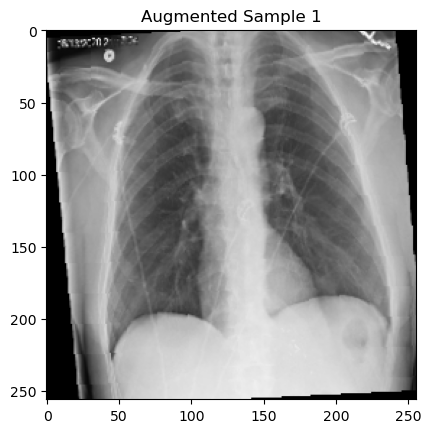

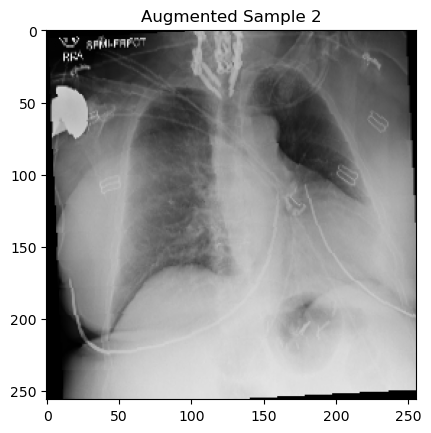

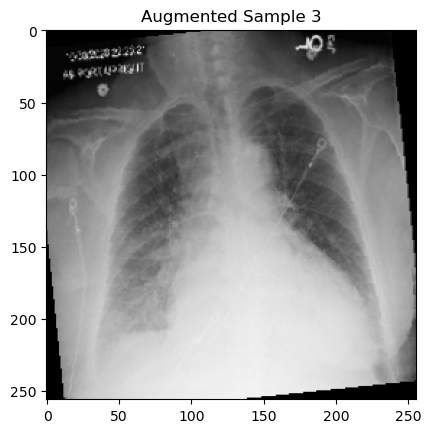

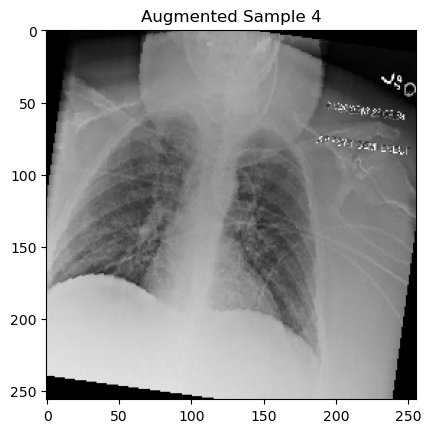

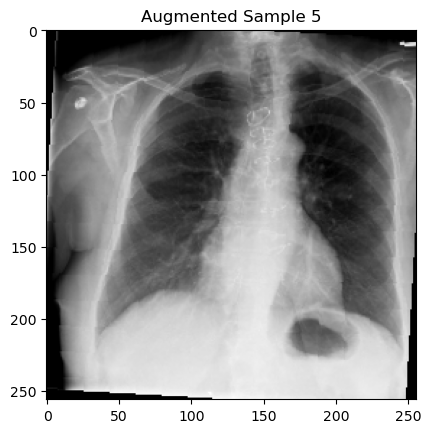

In [ ]:
# Visualize a few augmented samples
for i in range(5):
    img, _ = train_dataset[i]
    plt.imshow(img[0].cpu(), cmap='gray')
    plt.title(f"Augmented Sample {i+1}")
    plt.show()


In [ ]:
batch_size = 16  # smaller batch reduces memory and speeds epochs
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


## 8. Create and Initialize Model


## 9. Train the Model


In [ ]:
# ✅ Use pretrained model (already defined above)
trainer = BNPPTrainer(model, train_loader, val_loader, test_loader, device)

# Run a quick training cycle (e.g. 3 epochs first to test)
train_losses, val_losses, val_r_scores, val_pearson_coeffs, val_p_values = trainer.train(num_epochs=3)

Starting training for 3 epochs...


Validating: 100%|██████████| 21/21 [01:02<00:00,  3.00s/it]


Training completed!


## 10. Plot Training Curves


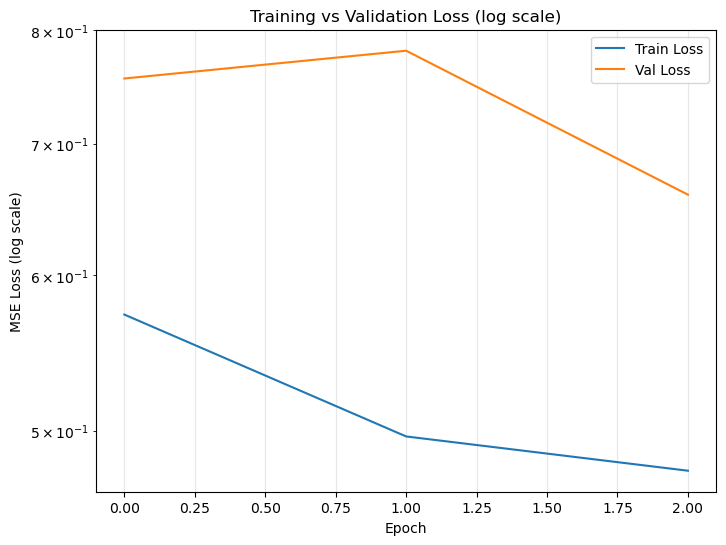

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.yscale('log')  # log-scale y-axis
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (log scale)')
plt.title('Training vs Validation Loss (log scale)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('training_val_loss_log.png', dpi=300, bbox_inches='tight')
plt.show()


## 12. Plot Actual vs Predicted (Log Scale)


In [55]:
# =====================================================
# 🧠 2. Run inference on the test set with TTA
# =====================================================
TTA_ROUNDS = 5  # number of augmented passes per image

all_predictions = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc=f"Predicting with {TTA_ROUNDS}x TTA"):
        images, labels = images.to(device), labels.to(device)
        tta_preds = []

        # Perform multiple augmented predictions
        for _ in range(TTA_ROUNDS):
            augmented = torch.stack([train_transforms(img.cpu()).to(device) for img in images])
            outputs = model(augmented).squeeze()
            tta_preds.append(outputs.cpu().numpy())

        # Average predictions across augmentations
        mean_preds = np.mean(tta_preds, axis=0)
        all_predictions.extend(mean_preds)
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
predictions = np.array(all_predictions)
actual = np.array(all_labels)




Predicting with 5x TTA: 100%|██████████| 21/21 [04:48<00:00, 13.72s/it]


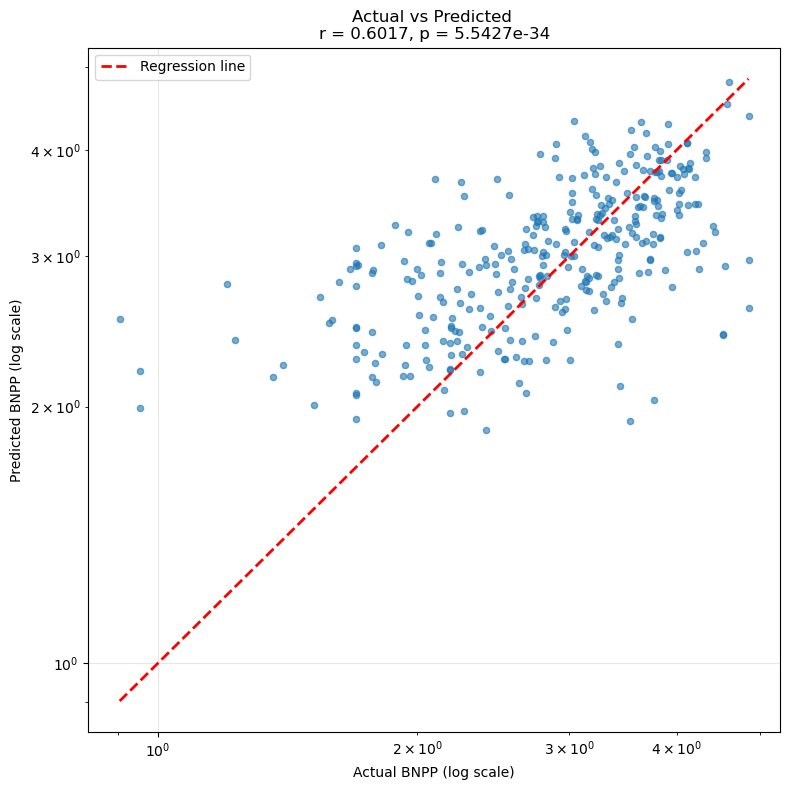

✅ Pearson correlation (r): 0.6017
p-value: 5.5427e-34


In [58]:
plt.figure(figsize=(8, 8))
plt.scatter(actual, predictions, alpha=0.6, s=20)
min_val = min(min(actual), min(predictions))
max_val = max(max(actual), max(predictions))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Regression line')

# Compute Pearson r (and p-value)
r, pval = pearsonr(actual, predictions)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Actual BNPP (log scale)')
plt.ylabel('Predicted BNPP (log scale)')
plt.title(f'Actual vs Predicted \nr = {r:.4f}, p = {pval:.4e}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('actual_vs_predicted_TTA.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Pearson correlation (r): {r:.4f}")
print(f"p-value: {pval:.4e}")
